In [62]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

In [65]:
# Reflect Tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

In [66]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [70]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [71]:
# Create the inspector and connect it to the engine
connection = inspect(engine) 

# Collect the names of tables within the measurement database
hawaiiDBcolumns = connection.get_columns('measurement')

#Get hawaiiDBcolumn info
for hawaiiDBcolumn in hawaiiDBcolumns:
    print(hawaiiDBcolumn['name'], hawaiiDBcolumn['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [72]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastDB_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

lastDB_data_point

('2017-08-23')

In [73]:
#calculate the year ago from the above date
Date_Year_Ago_Frm_lasDBdatapoint = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(Date_Year_Ago_Frm_lasDBdatapoint)



2016-08-23


In [74]:
# Perform a query to retrieve the data and precipitation scores
Precipitation_Scr = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= Date_Year_Ago_Frm_lasDBdatapoint, Measurement.prcp!= None).\
            order_by(Measurement.date).all()



In [75]:
# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_DB_Precipitation = pd.DataFrame(Precipitation_Scr, columns = ['date', 'precipitation']).dropna()
hawaii_DB_Precipitation.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


In [76]:
# Sort the dataframe by date
hawaii_DB_Precipitation.set_index('date', inplace = True)
hawaii_DB_Precipitation.head()
hawaii_DB_Precipitation.index

Index(['2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23',
       '2016-08-23', '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
       ...
       '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22', '2017-08-22',
       '2017-08-22', '2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23'],
      dtype='object', name='date', length=2021)

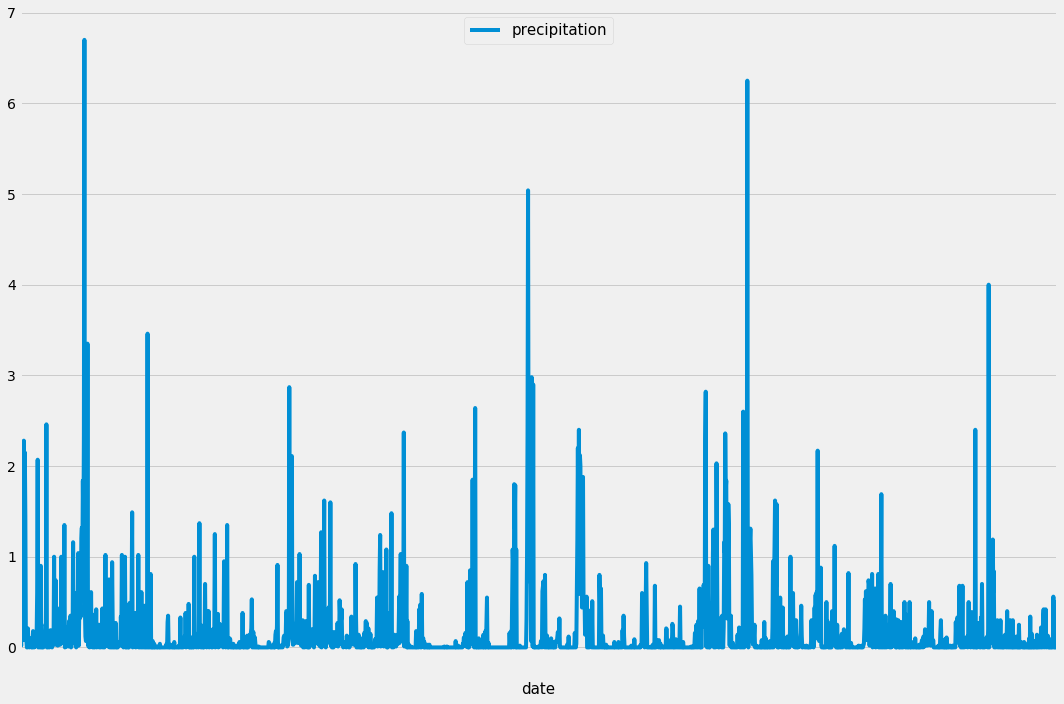

In [77]:
# Use Pandas Plotting with Matplotlib to plot the data
hawaii_DB_Precipitation.plot(figsize=(15,10))

# labeling the plot
plt.legend(loc = 'upper center', fontsize = 15 )
plt.tight_layout()
plt.xlabel('date', fontsize = 15)
plt.xticks([])
plt.tight_layout()

plt.savefig('Images/Precipitation.png')


In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_DB_Precipitation.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [79]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [80]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Station_Counts_In_Desc = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for row in Station_Counts_In_Desc:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_tmp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs).first()
highest_tmp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs.desc()).first()
mean_tmp = session.query(func.avg(Measurement.tobs)).\
             filter_by(station = 'USC00519281').all()
                          
print([lowest_tmp[0], highest_tmp[0], mean_tmp[0][0]])

[54.0, 85.0, 71.66378066378067]


In [88]:
# Choose the station with the highest number of temperature observations.
station_with_highestNo = session.query(Measurement.station).group_by(Measurement.station).\
           order_by(func.count(Measurement.tobs).desc()).first()[0]


station_with_highestNo

'USC00519281'

In [91]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lasttwelvemonth_tmp = session.query(Measurement.tobs).filter(Measurement.date >= Date_Year_Ago_Frm_lasDBdatapoint, Measurement.station == "USC00519281").\
                    order_by(Measurement.tobs).all()

# Save the query results as a Pandas DataFrame
results = pd.DataFrame(lasttwelvemonth_tmp, columns=["Tobs"])
results.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


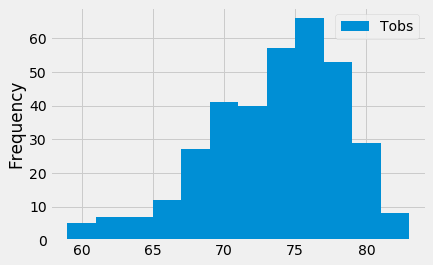

In [92]:
#Plot the results as a histogram with bins=12.
bins = 12
results.plot.hist(lasttwelvemonth_tmp, bins)
plt.savefig("Images/Station_Histogram.png")